# 7 MUSCLES CLASSIFICATION WITH (INTRA+INTER)PERSONAL VALIDATION

In [1]:
# Installation of BioSignalsNotebooks
# %pip install biosignalsnotebooks

In [2]:
# Imports
import os
import glob
import shutil
import pickle
import numpy as np
import pandas as pd
from tabulate import tabulate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import biosignalsnotebooks as bsnb
import plotly.graph_objects as go

# Tensorflow Model
import tensorflow as tf
from functools import reduce
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Conv1D, LeakyReLU, MaxPooling1D, LSTM, GlobalAveragePooling1D, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import categorical_crossentropy

# Weight and Biases
import wandb
from wandb.keras import WandbMetricsLogger

# Model Metrics
import seaborn as sn
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

In [3]:
# Defining Randomness Seeds for Reproducibility
np.random.seed(16)
tf.random.set_seed(16)

## 1) sEMG Signal Processing

### Creating the sEMG Signal Dataframes from the CSV files

In [4]:
def subject_df_creator(subject_id, muscles_of_interest):
	"""
    Collects the data from all trial files for each subject and stores it in a DataFrame
	:param subject_id: string
	:param muscles_of_interest: list of strings
	:return: A concatenated DataFrame containing the data for all specified muscles from all valid trials.
	"""
	trials_dfs_list = []
	output_msg=[]

	# Iterating over the subject files
	for trial_number in tqdm(range(1, 51), desc=f"Concatenating trial Files for Subject AB{subject_id}"):
	    filename = f"5362627/AB{subject_id}/AB{subject_id}/Raw/AB{subject_id}_Circuit_0{trial_number:02d}_raw.csv"
	    # Checking if the file exists
	    if not os.path.exists(filename):  
	        output_msg.append(f"0{trial_number:02d}")
	        continue

	    df_trial = pd.read_csv(filename)
	    df_trial_combined = pd.DataFrame()

	    # Concatenating "Right_" and "Left_" values for each muscle of interest
	    for i in range(len(muscles_of_interest)):
	        df_trial_combined[muscles_of_interest[i]] = pd.concat([df_trial["Right_"+muscles_of_interest[i]], df_trial["Left_"+muscles_of_interest[i]]], ignore_index=True)

	    trials_dfs_list.append(df_trial_combined)

	# Concatenating all DataFrames in the list into a single DataFrame
	merged_df = pd.concat(trials_dfs_list, ignore_index=True)

	# Printing the missing files
	if output_msg:
	    print(f"{len(output_msg)} Files do not exist:", output_msg)

	return merged_df

In [5]:
# Defining the subject_ids list and muscles list to use for printing 
subjects = ["156", "185", "186", "188", "189", "190", "191", "192", "193", "194"]
muscles = ["TA", "MG", "SOL", "BF", "ST", "VL", "RF"]

In [6]:
# Creating dataframes to save subject-specific data
df_subject_156 = subject_df_creator(subjects[0], muscles)
df_subject_185 = subject_df_creator(subjects[1], muscles)
df_subject_186 = subject_df_creator(subjects[2], muscles)
df_subject_188 = subject_df_creator(subjects[3], muscles)
df_subject_189 = subject_df_creator(subjects[4], muscles)
df_subject_190 = subject_df_creator(subjects[5], muscles)
df_subject_191 = subject_df_creator(subjects[6], muscles)
df_subject_192 = subject_df_creator(subjects[7], muscles)
df_subject_193 = subject_df_creator(subjects[8], muscles)
df_subject_194 = subject_df_creator(subjects[9], muscles)

In [7]:
# Saving the Dataframes into pickle objects to save time and to be able to run the code without needing the whole dataset
df_subject_156.to_pickle("pickled_dataframes/df_subject_156.pkl")
df_subject_185.to_pickle("pickled_dataframes/df_subject_185.pkl")
df_subject_186.to_pickle("pickled_dataframes/df_subject_186.pkl")
df_subject_188.to_pickle("pickled_dataframes/df_subject_188.pkl")
df_subject_189.to_pickle("pickled_dataframes/df_subject_189.pkl")
df_subject_190.to_pickle("pickled_dataframes/df_subject_190.pkl")
df_subject_191.to_pickle("pickled_dataframes/df_subject_191.pkl")
df_subject_192.to_pickle("pickled_dataframes/df_subject_192.pkl")
df_subject_193.to_pickle("pickled_dataframes/df_subject_193.pkl")
df_subject_194.to_pickle("pickled_dataframes/df_subject_194.pkl")

In [8]:
# Loading pickle files into DataFrames
df_subject_156 = pd.read_pickle("pickled_dataframes/df_subject_156.pkl")
df_subject_185 = pd.read_pickle("pickled_dataframes/df_subject_185.pkl")
df_subject_186 = pd.read_pickle("pickled_dataframes/df_subject_186.pkl")
df_subject_188 = pd.read_pickle("pickled_dataframes/df_subject_188.pkl")
df_subject_189 = pd.read_pickle("pickled_dataframes/df_subject_189.pkl")
df_subject_190 = pd.read_pickle("pickled_dataframes/df_subject_190.pkl")
df_subject_191 = pd.read_pickle("pickled_dataframes/df_subject_191.pkl")
df_subject_192 = pd.read_pickle("pickled_dataframes/df_subject_192.pkl")
df_subject_193 = pd.read_pickle("pickled_dataframes/df_subject_193.pkl")
df_subject_194 = pd.read_pickle("pickled_dataframes/df_subject_194.pkl")

In [9]:
# Merging all the subject dataframes into one
list_of_all_subjects_dfs = [df_subject_156, df_subject_185, df_subject_186, df_subject_188, df_subject_189,
                            df_subject_190, df_subject_191, df_subject_192, df_subject_193, df_subject_194]

df_all_subjects = pd.concat(list_of_all_subjects_dfs, ignore_index=True)

In [10]:
# Safety Check
df_all_subjects

,TA,MG,SOL,BF,ST,VL,RF
0,-0.110857,-0.078660,-0.077287,-0.073320,-0.107652,-0.075303,-0.069352
1,-0.094835,-0.069810,-0.068132,-0.071031,-0.103227,-0.072251,-0.062943
2,-0.083238,-0.055314,-0.057298,-0.064775,-0.096361,-0.067063,-0.055772
3,-0.076219,-0.051194,-0.052110,-0.059281,-0.091478,-0.066148,-0.049821
4,-0.071336,-0.048295,-0.049363,-0.058976,-0.093614,-0.064622,-0.049668
...,...,...,...,...,...,...,...
23351875,-0.089799,-0.063249,-0.095598,-0.070573,-0.103685,-0.042039,-0.072404
23351876,-0.094224,-0.061875,-0.082628,-0.072709,-0.088273,-0.052720,-0.062028
23351877,-0.093767,-0.059892,-0.076371,-0.072709,-0.078202,-0.051804,-0.055924
23351878,-0.096666,-0.061112,-0.072251,-0.075151,-0.070878,-0.055009,-0.052567


### EMG Signal Visualisation 

In [11]:
# Visualising a sample of the TA muscle (Warning: Might make the notebook buggy) 
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=df_all_subjects.index/1000, y=df_all_subjects["TA"][:5000]))
fig1.update_layout( title="sEMG Signal Sample: Sitting Vs Contraction Bursts Vs Rest", xaxis_title="Time (s)",
                    yaxis_title="sEMG Activity (V)", margin=dict(l=50, r=50, b=50, t=50, pad=4),
                    autosize=False, width=800, height=301)
fig1.show()

### EMG Signal Analysis

In [12]:
df_analysis = pd.DataFrame()
df_analysis["Mean"] = df_all_subjects.mean()
df_analysis["Std"] = df_all_subjects.std()
df_analysis["Var"] = df_all_subjects.var()
df_analysis

,Mean,Std,Var
TA,-0.095527,0.053082,0.002818
MG,-0.067019,0.046308,0.002144
SOL,-0.078862,0.053928,0.002908
BF,-0.074807,0.034799,0.001211
ST,-0.092018,0.027390,0.000750
VL,-0.063718,0.041050,0.001685
RF,-0.064333,0.021242,0.000451


In [13]:
# Studying the mean, sigma and variance of individual subjects
for idx, df in enumerate(list_of_all_subjects_dfs):
    # Creating an "analysis" DataFrame for the current subject
    subject_stats_df = pd.DataFrame({"Mean": df.mean(), "Std": df.std(),"Var": df.var()})#.transpose() # For making the muscles into rows 

    # Printing the table for the current subject
    print(f"- EMG Analysis for Subject_{subjects[idx]}:")
    print(tabulate(subject_stats_df.round(4), headers="keys", tablefmt="grid"))
    print("\n")  

## 2) Muscle Bursts Detection

In [14]:
# Saving the detected bursts for every muscle (takes an eternity, make sure to start it from your previous life)
sr = 1000 # sample rate = 1000Hz
sl = 20 # smooth level (Size of sliding window used during the moving average process) # Empirical
th = 10 # threshold (To cover activation)

# Initializing lists
detected_bursts_TA = [] ; detected_bursts_MG = [] ; detected_bursts_SOL= []
detected_bursts_BF = [] ; detected_bursts_ST = [] ; detected_bursts_VL = []
detected_bursts_RF = []

# Iterating over every subject to detect and append their muscle bursts to the proper detecting list 
pbar = tqdm(total=len(muscles)*len(list_of_all_subjects_dfs), desc="All Subjects Burst Detection Progress", unit= "Muscle")
for df_subject in list_of_all_subjects_dfs:
    ## TA
    detected_bursts_TA.append(bsnb.detect_emg_activations(emg_signal=df_subject["TA"], sample_rate=sr, smooth_level=sl,
                                                          threshold_level=th, time_units=True, device="CH0", plot_result= False))
    pbar.update(1)  # Update progress bar
    ## MG
    detected_bursts_MG.append(bsnb.detect_emg_activations(emg_signal=df_subject["MG"], sample_rate=sr, smooth_level=sl,
                                                          threshold_level=th, time_units=True, device="CH0", plot_result= False))
    pbar.update(1)
    ## SOL
    detected_bursts_SOL.append(bsnb.detect_emg_activations(emg_signal=df_subject["SOL"], sample_rate=sr, smooth_level=sl,
                                                           threshold_level=th, time_units=True, device="CH0", plot_result= False))
    pbar.update(1)
    ## BF
    detected_bursts_BF.append(bsnb.detect_emg_activations(emg_signal=df_subject["BF"], sample_rate=sr, smooth_level=sl,
                                                          threshold_level=th, time_units=True, device="CH0", plot_result= False))
    pbar.update(1)
    ## ST
    detected_bursts_ST.append(bsnb.detect_emg_activations(emg_signal=df_subject["ST"], sample_rate=sr, smooth_level=sl,
                                                          threshold_level=th, time_units=True, device="CH0", plot_result= False))
    pbar.update(1)
    ## VL
    detected_bursts_VL.append(bsnb.detect_emg_activations(emg_signal=df_subject["VL"], sample_rate=sr, smooth_level=sl,
                                                          threshold_level=th, time_units=True, device="CH0", plot_result= False))
    pbar.update(1)
    ## RF
    detected_bursts_RF.append(bsnb.detect_emg_activations(emg_signal=df_subject["RF"], sample_rate=sr, smooth_level=sl,
                                                          threshold_level=th, time_units=True, device="CH0", plot_result= False))
    pbar.update(1)

In [15]:
# Creating the pickles objects to save the burst detection results (saves about 29 minutes)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_TA.pkl", "wb") as f: pickle.dump(detected_bursts_TA, f)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_MG.pkl", "wb") as f: pickle.dump(detected_bursts_MG, f)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_SOL.pkl","wb") as f: pickle.dump(detected_bursts_SOL,f)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_BF.pkl", "wb") as f: pickle.dump(detected_bursts_BF, f)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_ST.pkl", "wb") as f: pickle.dump(detected_bursts_ST, f)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_VL.pkl", "wb") as f: pickle.dump(detected_bursts_VL, f)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_RF.pkl", "wb") as f: pickle.dump(detected_bursts_RF, f)

In [16]:
# Loading the pickle objects
pbar = tqdm(total=len(muscles), desc="Burst Detection Loading Progress", unit= "Muscle")
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_TA.pkl", "rb") as f: detected_bursts_TA = pickle.load(f)
pbar.update(1)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_MG.pkl", "rb") as f: detected_bursts_MG = pickle.load(f)
pbar.update(1)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_SOL.pkl","rb") as f: detected_bursts_SOL= pickle.load(f)
pbar.update(1)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_BF.pkl", "rb") as f: detected_bursts_BF = pickle.load(f)
pbar.update(1)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_ST.pkl", "rb") as f: detected_bursts_ST = pickle.load(f)
pbar.update(1)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_VL.pkl", "rb") as f: detected_bursts_VL = pickle.load(f)
pbar.update(1)
with open("pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_RF.pkl", "rb") as f: detected_bursts_RF = pickle.load(f)
pbar.update(1)

Burst Detection Loading Progress:   0%|          | 0/7 [00:00<?, ?Muscle/s]

True

In [17]:
# Safety Check (output is 1 array with 4 arrays inside the firs two are [start times] [end times])  
pd.DataFrame(detected_bursts_SOL[:][:10]).transpose()

### Detected Bursts Visualisation

In [18]:
# Visualising the EMG Burst Detection for SOL (bsnb has a weird behaviour, the longer the input the less reliable it is) 
plot_duration = 40000 # time in milliseconds
bsnb.detect_emg_activations(emg_signal = df_all_subjects["SOL"][:plot_duration], sample_rate = sr, smooth_level=sl, threshold_level=th, time_units=True, device="CH0", plot_result= True)
print("")

In [19]:
# Visualising the EMG Burst Detection for TA with offset for Subject_156 
duration = 5000
shift = 0
number_bursts_to_plot = 1

plt.rcParams["figure.figsize"] = (10,5)
fig = plt.figure()

plt.plot(df_all_subjects["TA"][:duration], color="cornflowerblue")
for i in range(number_bursts_to_plot): # Plot first N bursts
    plt.axvline(detected_bursts_TA[1][0][i+1], color="red", label="Detected Burst Region") # ONSET VERTICAL LINE
    plt.axvline(detected_bursts_TA[1][1][i+1], color="red") # OFFSET VERTICAL LINE
    plt.axvline(detected_bursts_TA[1][0][i+1]+1000, color="black", label="Onset Window (1000ms)") # ONSET VERTICAL LINE CORRECTED (START WINDOW)
    plt.axvline(detected_bursts_TA[1][0][i+1]-100, color="black") # VERTICAL LINE (END WINDOW)

plt.legend(loc="upper left")
plt.xlim(shift, duration)
plt.grid()
plt.xlabel("Time (ms)", fontsize=10)
plt.ylabel("sEMG Intensity (V)", fontsize=10)

In [62]:
# adding figures and traces
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x= df_all_subjects.index/1000, y=df_all_subjects["TA"]))
# formatting the plot
fig1.update_layout(autosize=True, title="sEMG Signal: Detection of Activation Bursts",
                   xaxis_title="Time (s)", yaxis_title="sEMG Activity (V)",
                   margin=dict(l=50, r=50, b=50, t=50, pad=4))

for i in range(len(detected_bursts_TA[0])):
    fig1.add_vrect(x0=detected_bursts_TA[0][i], x1=detected_bursts_TA[1][i], row="all", col=1,
                   annotation_text="Detected Burst", annotation_position="top right",
                   fillcolor="black", opacity=0.25, line_width=0)

# fig1.update_xaxes(range=[30, 60])
fig1.update_layout(autosize=False, width=800, height=301)
# plotting
fig1.show()

### Detected Bursts Analysis 

#### Number of Detected Bursts

In [20]:
# Defining Variables to store the total number of bursts for every muscle 
tot_bursts_TA = [] ; tot_bursts_MG = [] ; tot_bursts_SOL = []
tot_bursts_BF = [] ; tot_bursts_ST = [] ; tot_bursts_VL = []
tot_bursts_RF = [] ; burst_count_list_for_printing = []

# Calculating the total number of bursts per muscle
for subject_idx, subject in enumerate(subjects):
    tot_bursts_TA.append(len(detected_bursts_TA[subject_idx][0]))
    tot_bursts_MG.append(len(detected_bursts_MG[subject_idx][0]))
    tot_bursts_SOL.append(len(detected_bursts_SOL[subject_idx][0]))
    tot_bursts_BF.append(len(detected_bursts_BF[subject_idx][0]))
    tot_bursts_ST.append(len(detected_bursts_ST[subject_idx][0]))
    tot_bursts_VL.append(len(detected_bursts_VL[subject_idx][0]))
    tot_bursts_RF.append(len(detected_bursts_RF[subject_idx][0]))

    # Calculate the total bursts for each subject across all muscles
    total_bursts_subject = (tot_bursts_TA[subject_idx] + tot_bursts_MG[subject_idx] +
                            tot_bursts_SOL[subject_idx] + tot_bursts_BF[subject_idx] +
                            tot_bursts_ST[subject_idx] + tot_bursts_VL[subject_idx] +
                            tot_bursts_RF[subject_idx])

    # Saving the results in a list for fancy printing
    burst_count_list_for_printing.append([subject, tot_bursts_TA[subject_idx], tot_bursts_MG[subject_idx], tot_bursts_SOL[subject_idx],
                                          tot_bursts_BF[subject_idx], tot_bursts_ST[subject_idx], tot_bursts_VL[subject_idx],
                                          tot_bursts_RF[subject_idx], total_bursts_subject])

# Adding the total row to the printing
burst_count_list_for_printing.append(["* Total Sum", sum(tot_bursts_TA), sum(tot_bursts_MG), sum(tot_bursts_SOL), sum(tot_bursts_BF),
                                      sum(tot_bursts_ST), sum(tot_bursts_VL), sum(tot_bursts_RF),
                                      sum(tot_bursts_TA) + sum(tot_bursts_MG) + sum(tot_bursts_SOL) + sum(tot_bursts_BF) +
                                      sum(tot_bursts_ST) + sum(tot_bursts_VL) + sum(tot_bursts_RF)])

# Printing the table
print("Number of Muscle Bursts Per Subject Per Muscle:\n")
headers = ["Subject", "TA Bursts", "MG Bursts", "SOL Bursts", "BF Bursts", "ST Bursts", "VL Bursts", "RF Bursts", "Total Bursts"]
print(tabulate(burst_count_list_for_printing, headers=headers, tablefmt="grid"))

Number of Muscle Bursts Per Subject Per Muscle:

+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+----------------+
| Subject     |   TA Bursts |   MG Bursts |   SOL Bursts |   BF Bursts |   ST Bursts |   VL Bursts |   RF Bursts |   Total Bursts |
+=============+=============+=============+==============+=============+=============+=============+=============+================+
| 156         |         452 |         760 |          296 |         815 |          40 |         214 |         156 |           2733 |
+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+----------------+
| 185         |         399 |         948 |          832 |         742 |         736 |        1132 |        1117 |           5906 |
+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+----------------+
| 186         |         398

#### Longest Detected Bursts

In [21]:
# Lists to store longest burst per muscle for all subjects
longest_bursts_TA = []; longest_bursts_MG = []; longest_bursts_SOL = []
longest_bursts_BF = []; longest_bursts_ST = []; longest_bursts_VL = []
longest_bursts_RF = []
longest_burst_list_for_printing = []

# Calculating the longest burst per muscle
for subject_idx, subject in enumerate(subjects):
    longest_TA = max(np.array(detected_bursts_TA[subject_idx][1])-np.array(detected_bursts_TA[subject_idx][0]))
    longest_MG = max(np.array(detected_bursts_MG[subject_idx][1])-np.array(detected_bursts_MG[subject_idx][0]))
    longest_SOL = max(np.array(detected_bursts_SOL[subject_idx][1])-np.array(detected_bursts_SOL[subject_idx][0]))
    longest_BF = max(np.array(detected_bursts_BF[subject_idx][1])-np.array(detected_bursts_BF[subject_idx][0]))
    longest_ST = max(np.array(detected_bursts_ST[subject_idx][1])-np.array(detected_bursts_ST[subject_idx][0]))
    longest_VL = max(np.array(detected_bursts_VL[subject_idx][1])-np.array(detected_bursts_VL[subject_idx][0]))
    longest_RF = max(np.array(detected_bursts_RF[subject_idx][1])-np.array(detected_bursts_RF[subject_idx][0]))

    # Save longest burst per muscle for this subject
    longest_bursts_TA.append(longest_TA)
    longest_bursts_MG.append(longest_MG)
    longest_bursts_SOL.append(longest_SOL)
    longest_bursts_BF.append(longest_BF)
    longest_bursts_ST.append(longest_ST)
    longest_bursts_VL.append(longest_VL)
    longest_bursts_RF.append(longest_RF)

    # Calculate the longest burst across all muscles for the subject
    longest_burst_subject = max(longest_TA, longest_MG, longest_SOL, longest_BF, longest_ST, longest_VL, longest_RF)

    # Save the results in a list for printing
    longest_burst_list_for_printing.append([subject, longest_TA, longest_MG, longest_SOL, longest_BF, longest_ST, longest_VL, longest_RF, longest_burst_subject])

# Adding the longest burst across all subjects per muscle and overall
longest_burst_list_for_printing.append(["* Longest Burst", max(longest_bursts_TA), max(longest_bursts_MG),
                                        max(longest_bursts_SOL), max(longest_bursts_BF),
                                        max(longest_bursts_ST), max(longest_bursts_VL),
                                        max(longest_bursts_RF), max([max(longest_bursts_TA), max(longest_bursts_MG), max(longest_bursts_SOL),
                                                                     max(longest_bursts_BF), max(longest_bursts_ST), max(longest_bursts_VL), max(longest_bursts_RF)])])

# Printing the table
print("Longest Burst Per Subject Per Muscle:\n")
headers = ["Subject", "TA (s)", "MG (s)", "SOL (s)", "BF (s)", "ST (s)", "VL (s)", "RF (s)", "Per Subject (s)"]
print(tabulate(longest_burst_list_for_printing, headers=headers, tablefmt="grid"))

Longest Burst Per Subject Per Muscle:

+-----------------+----------+----------+-----------+----------+----------+----------+----------+-------------------+
| Subject         |   TA (s) |   MG (s) |   SOL (s) |   BF (s) |   ST (s) |   VL (s) |   RF (s) |   Per Subject (s) |
+=================+==========+==========+===========+==========+==========+==========+==========+===================+
| 156             |    2.439 |    2.515 |     1.666 |    6.978 |    1.549 |    1.3   |    1.136 |             6.978 |
+-----------------+----------+----------+-----------+----------+----------+----------+----------+-------------------+
| 185             |    2.144 |    1.145 |     2.081 |    1.206 |    2.13  |    6.104 |    7.858 |             7.858 |
+-----------------+----------+----------+-----------+----------+----------+----------+----------+-------------------+
| 186             |    3.562 |    1.2   |     6.879 |    1.339 |    1.393 |    2.755 |   14.415 |            14.415 |
+----------------

#### Average Detected Bursts Lengths

In [22]:
# Lists to store average burst length per muscle for all subjects
average_burst_lengths_TA = [] ; average_burst_lengths_MG = []
average_burst_lengths_SOL = []; average_burst_lengths_BF = []
average_burst_lengths_ST = [] ; average_burst_lengths_VL = []
average_burst_lengths_RF = [] ; avg_burst_len_list_for_printing = []

# Maximum allowed burst duration
max_duration = 2

# Calculating average burst length per muscle, excluding bursts longer than 2 seconds
for subject_idx, subject in enumerate(subjects):
    bursts_TA = np.array(detected_bursts_TA[subject_idx][1]) - np.array(detected_bursts_TA[subject_idx][0])
    bursts_MG = np.array(detected_bursts_MG[subject_idx][1]) - np.array(detected_bursts_MG[subject_idx][0])
    bursts_SOL = np.array(detected_bursts_SOL[subject_idx][1]) - np.array(detected_bursts_SOL[subject_idx][0])
    bursts_BF = np.array(detected_bursts_BF[subject_idx][1]) - np.array(detected_bursts_BF[subject_idx][0])
    bursts_ST = np.array(detected_bursts_ST[subject_idx][1]) - np.array(detected_bursts_ST[subject_idx][0])
    bursts_VL = np.array(detected_bursts_VL[subject_idx][1]) - np.array(detected_bursts_VL[subject_idx][0])
    bursts_RF = np.array(detected_bursts_RF[subject_idx][1]) - np.array(detected_bursts_RF[subject_idx][0])

    # Filter bursts longer than 2 seconds
    filtered_bursts_TA = bursts_TA[bursts_TA <= max_duration]
    filtered_bursts_MG = bursts_MG[bursts_MG <= max_duration]
    filtered_bursts_SOL = bursts_SOL[bursts_SOL <= max_duration]
    filtered_bursts_BF = bursts_BF[bursts_BF <= max_duration]
    filtered_bursts_ST = bursts_ST[bursts_ST <= max_duration]
    filtered_bursts_VL = bursts_VL[bursts_VL <= max_duration]
    filtered_bursts_RF = bursts_RF[bursts_RF <= max_duration]

    # Calculate mean of filtered bursts
    mean_TA = np.mean(filtered_bursts_TA)
    mean_MG = np.mean(filtered_bursts_MG)
    mean_SOL = np.mean(filtered_bursts_SOL)
    mean_BF = np.mean(filtered_bursts_BF)
    mean_ST = np.mean(filtered_bursts_ST)
    mean_VL = np.mean(filtered_bursts_VL)
    mean_RF = np.mean(filtered_bursts_RF)

    average_burst_lengths_TA.append(mean_TA)
    average_burst_lengths_MG.append(mean_MG)
    average_burst_lengths_SOL.append(mean_SOL)
    average_burst_lengths_BF.append(mean_BF)
    average_burst_lengths_ST.append(mean_ST)
    average_burst_lengths_VL.append(mean_VL)
    average_burst_lengths_RF.append(mean_RF)

    # Calculate the average for the subject across all muscles
    subject_average = np.mean([mean_TA, mean_MG, mean_SOL, mean_BF, mean_ST, mean_VL, mean_RF])

    # Saving the results in a list for fancy printing
    avg_burst_len_list_for_printing.append([subject,
                                            round(mean_TA, 3),
                                            round(mean_MG, 3),
                                            round(mean_SOL, 3),
                                            round(mean_BF, 3),
                                            round(mean_ST, 3),
                                            round(mean_VL, 3),
                                            round(mean_RF, 3),
                                            round(subject_average, 3)])  # Include average per subject

# Adding the total row to the printing
avg_burst_len_list_for_printing.append(["* Avg. Len", round(np.mean(average_burst_lengths_TA), 3), round(np.mean(average_burst_lengths_MG), 3),
                                        round(np.mean(average_burst_lengths_SOL), 3), round(np.mean(average_burst_lengths_BF), 3),
                                        round(np.mean(average_burst_lengths_ST), 3), round(np.mean(average_burst_lengths_VL), 3),
                                        round(np.mean(average_burst_lengths_RF), 3)])
# Calculate the overall average length and append to the list for printing
avg_burst_len_list_for_printing.append(["* Overall Avg. Len", round(np.mean(average_burst_lengths_TA + average_burst_lengths_MG + average_burst_lengths_SOL + average_burst_lengths_BF + average_burst_lengths_ST + average_burst_lengths_VL + average_burst_lengths_RF), 3)])

# Printing the table
print(f"Average Burst Length in Seconds Per Subject Per Muscle (Excluding Muscle Bursts Longer than {max_duration} Seconds):\n")
headers = ["Subject", "TA Avg.Len", "MG Avg.Len", "SOL Avg.Len", "BF Avg.Len", "ST Avg.Len", "VL Avg.Len", "RF Avg.Len", "Avg. Per Subject"]
print(tabulate(avg_burst_len_list_for_printing, headers=headers, tablefmt="grid"))

Average Burst Length in Seconds Per Subject Per Muscle (Excluding Muscle Bursts Longer than 2 Seconds):

+--------------------+--------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------------+
| Subject            |   TA Avg.Len |   MG Avg.Len |   SOL Avg.Len |   BF Avg.Len |   ST Avg.Len |   VL Avg.Len |   RF Avg.Len |   Avg. Per Subject |
+====================+==============+==============+===============+==============+==============+==============+==============+====================+
| 156                |        0.457 |        0.472 |         0.381 |        0.564 |        0.279 |        0.515 |        0.438 |              0.444 |
+--------------------+--------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------------+
| 185                |        0.465 |        0.459 |         0.497 |        0.439 |        0.42  |        0.542 |        0.568 |              0.4

#### Histogram: Detected Bursts Lengths

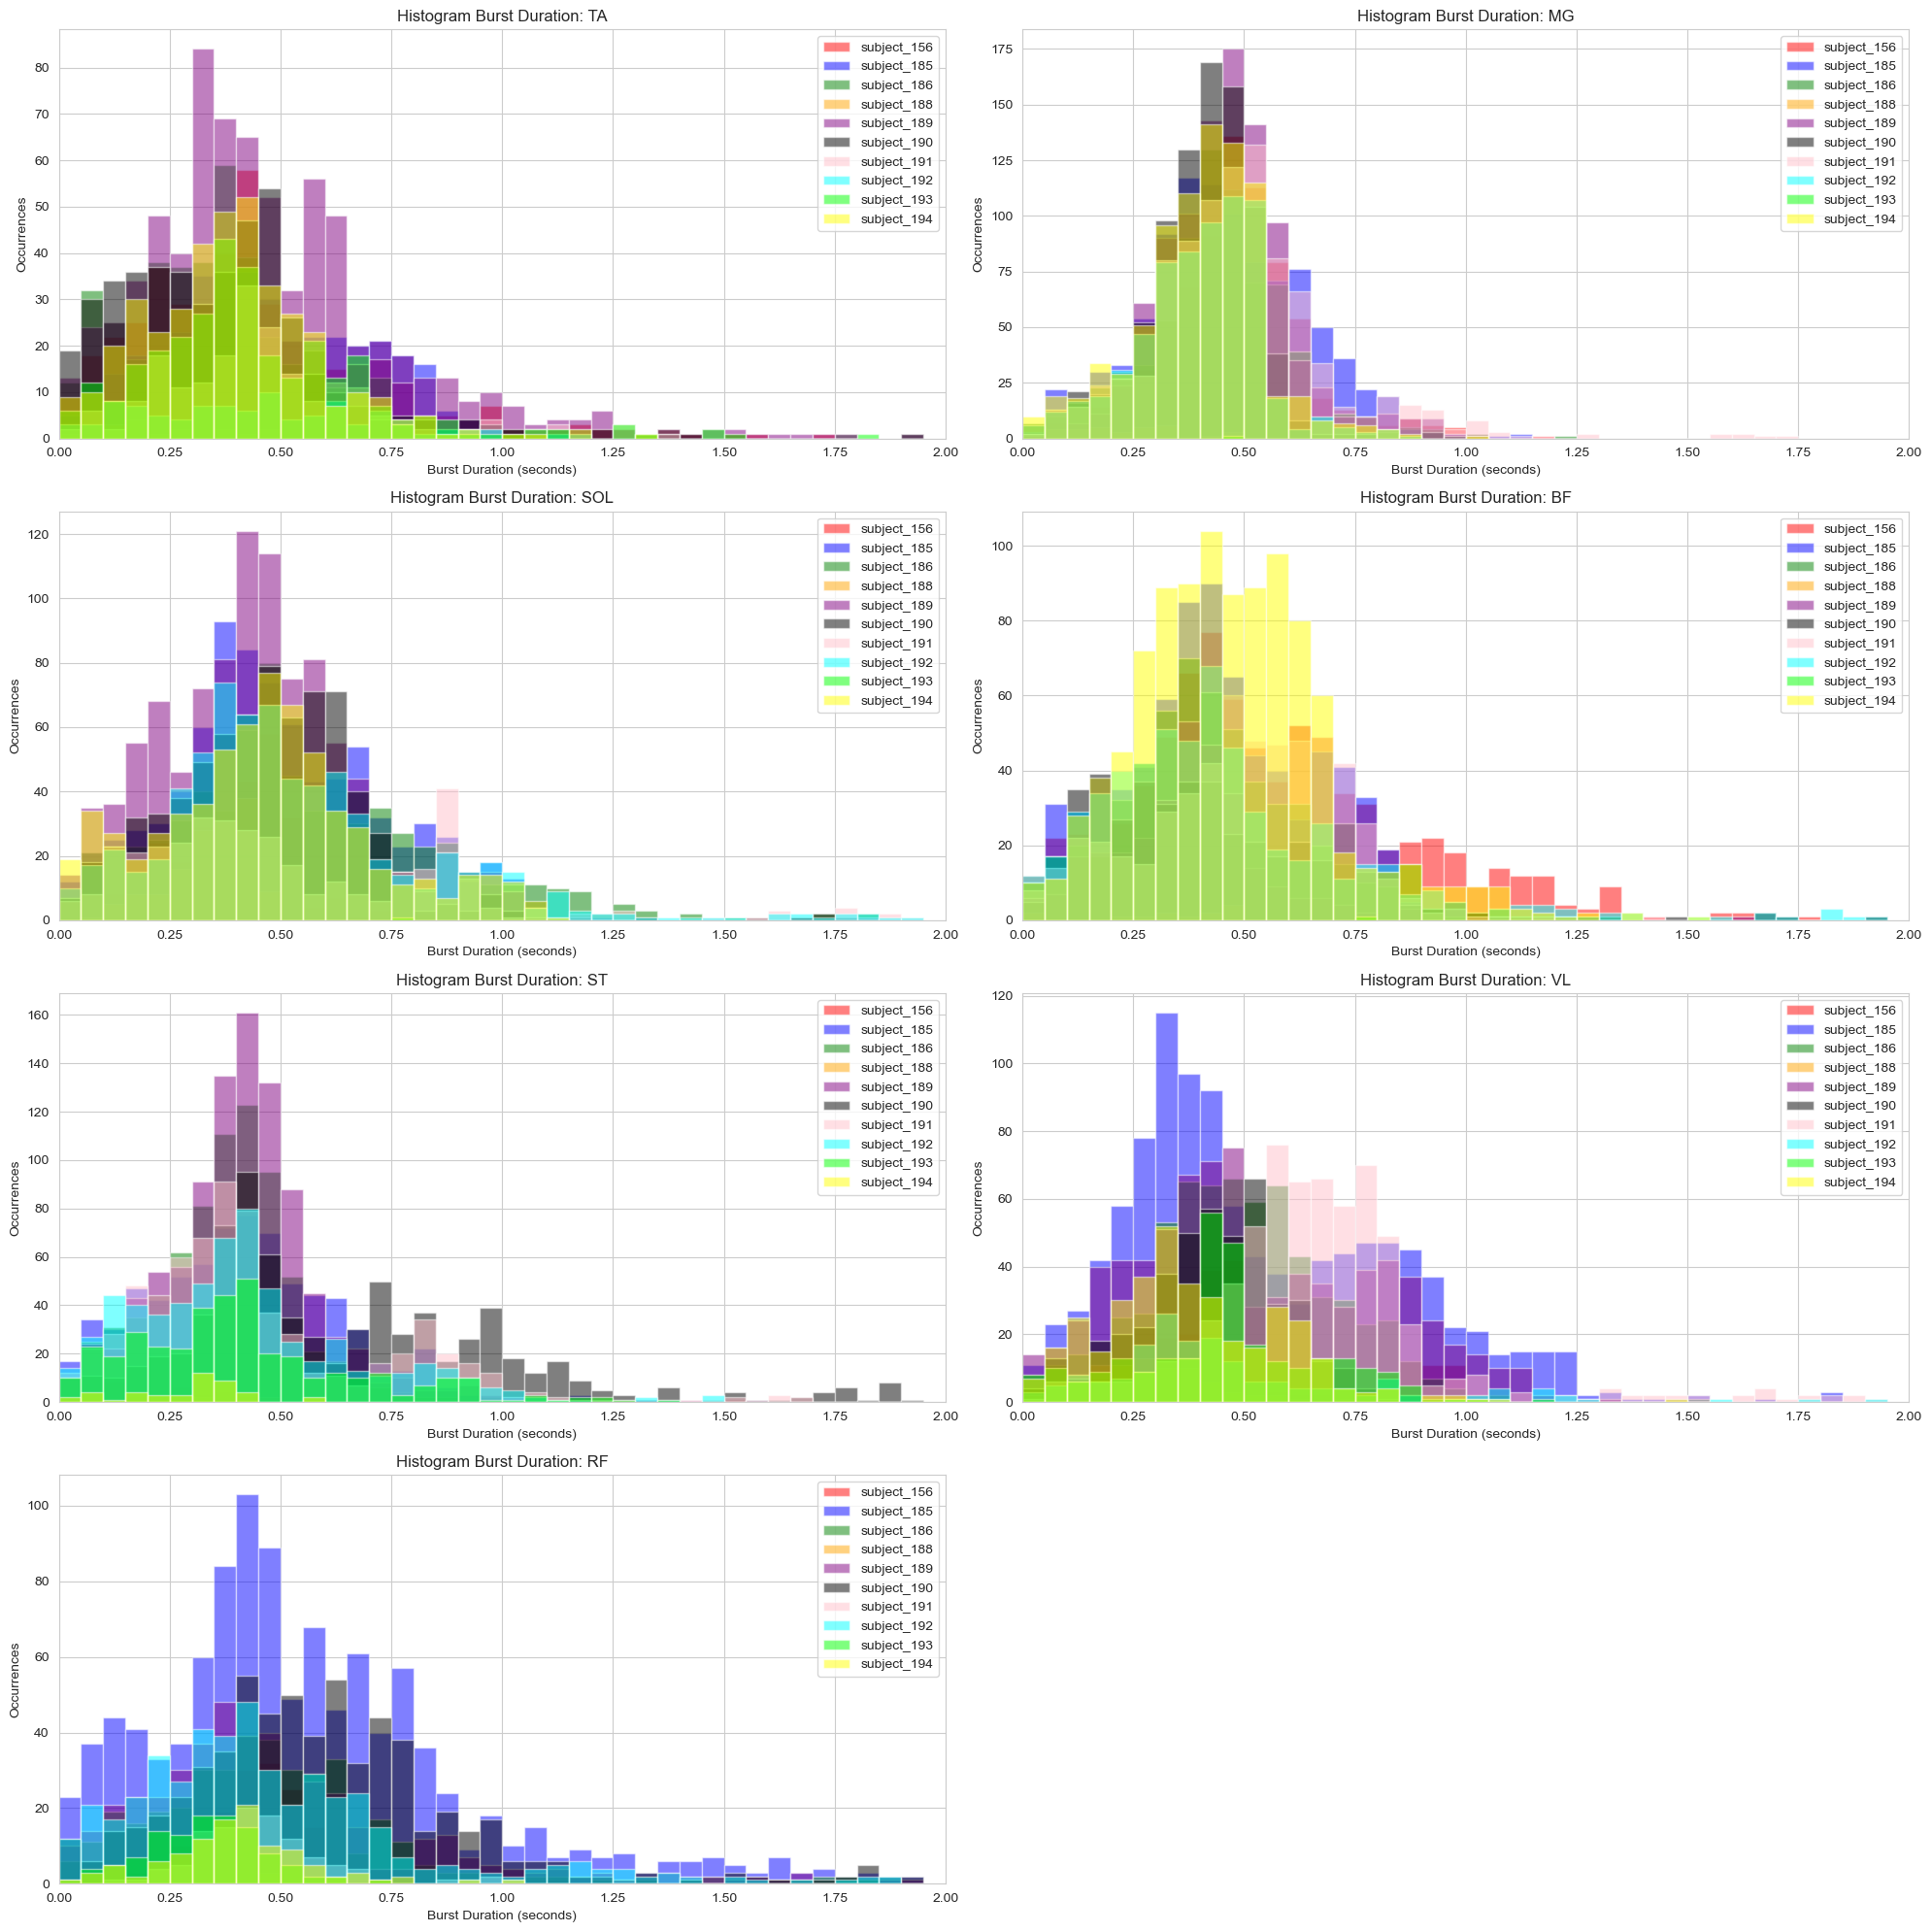

In [23]:
# Adjust subplot indexing
f, a = plt.subplots(4, 2, figsize=(20, 20))  # Change layout to 4 rows by 2 columns
a = a.ravel()
bin_edges = np.arange(start=0, stop=2, step=0.05)  # Example for bins of width 0.05
colors = ["red", "blue", "green", "orange", "purple", "black", "pink", "cyan", "lime", "yellow"]

for subject_idx, subject in enumerate(subjects):
	subject = "subject_" + subject
	a[0].hist(np.array(detected_bursts_TA[subject_idx][1])-np.array(detected_bursts_TA[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
	a[1].hist(np.array(detected_bursts_MG[subject_idx][1])-np.array(detected_bursts_MG[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
	a[2].hist(np.array(detected_bursts_SOL[subject_idx][1])-np.array(detected_bursts_SOL[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
	a[3].hist(np.array(detected_bursts_BF[subject_idx][1])-np.array(detected_bursts_BF[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
	a[4].hist(np.array(detected_bursts_ST[subject_idx][1])-np.array(detected_bursts_ST[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
	a[5].hist(np.array(detected_bursts_VL[subject_idx][1])-np.array(detected_bursts_VL[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
	a[6].hist(np.array(detected_bursts_RF[subject_idx][1])-np.array(detected_bursts_RF[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])

# Set legends, titles, and labels for each subplot
for muscle_idx, muscle in enumerate(muscles):
	a[muscle_idx].legend(loc="upper right")
	a[muscle_idx].set_title("Histogram Burst Duration: " + muscle)
	a[muscle_idx].set_xlabel("Burst Duration (seconds)")
	a[muscle_idx].set_ylabel("Occurrences")
	a[muscle_idx].set_xlim([0, 2])  # Remove to see how bad the burst detection is 

# Hide unused subplots if any
if len(muscles) < 8:
    for i in range(len(muscles), 8):
        a[i].set_visible(False)

plt.tight_layout()
plt.show()


### Extraction & Preprocessing

In [67]:
# Muscle Bursts Extraction: Using a Window size of 1000ms (including an onset of 100ms)
window = 1000 # total burst  window size, also model input
left_shift = 100 # onset size 

In [68]:
# WARNING: Tricky Function
def extract_burst_windows(muscle_emg_signal, onset_list, window_size, left_shift_value, muscle_name):
	"""
    The function iterates through each subject's list of onset times, extracting a window of EMG data around each onset. It accounts for potential overlap of windows by ensuring that a window does not extend into the next burst period. 
    If the end of a window does not overlap with the next onset, the window is extracted normally. If it is the last onset in the list, the window is extracted without checking for the next onset. 
    Each window is baseline corrected by subtracting the mean of the window to standardize the signal before analysis.
    
    :param muscle_emg_signal: Nested list where each sublist represents the EMG signal data for one subject.
	:param onset_list: A list containing the onset times of muscle activation for each subject.
	:param window_size: The number of samples to include in each window extracted around the onset point.
	:param left_shift_value: Number of samples to shift left from the onset point, defining the start of the window.
	:param muscle_name: The name of the muscle being processed, used for descriptive progress output.
	
	:return:  A nested list where each sublist contains processed EMG data windows for each burst detected in each subject's muscle signal.
	"""
	sampling_rate = 1000  # Define the sampling rate of the EMG signals
	all_subjects_burst_samples = []  # List to store burst windows for all subjects
	
    # Iterate over each subject to process burst windows
	for subject_index in tqdm(range(len(onset_list)), desc=f"Extracting Bursts for {muscle_name}"):
		current_subject_bursts = []  # List to store bursts for the current subject
		onset_list_indx = -1   # Index to track the position within the onset list for overlap checks
		
        # Iterate over each onset time for the current subject
		for onset in onset_list[subject_index][0]:
			onset_list_indx += 1
            # Calculate the starting sample index for the current burst window
			onset_ms = int(onset * sampling_rate) - left_shift_value
			
			current_sample_window = []  # List to store samples in the current window
			
            # Check if the current onset is not the last one
			if onset != onset_list[subject_index][0][-1]:
                # Check for overlap with the next burst onset
				if (onset_ms + window_size) < (onset_list[subject_index][0][onset_list_indx + 1] * 1000):
                    # Extract samples for the window if no overlap
					for time_step in range(window_size):
						current_sample_window.append(muscle_emg_signal[onset_ms + time_step])
			else:
                # Extract samples for the last burst window
				for time_step in range(window_size):
					current_sample_window.append(muscle_emg_signal[onset_ms + time_step])

            # Perform baseline correction by subtracting the mean of the window
			if current_sample_window:
				current_sample_window -= np.mean(current_sample_window)
				current_subject_bursts.append(current_sample_window)
				
        # Append the bursts for the current subject to the main list
		all_subjects_burst_samples.append(current_subject_bursts)
		
	return all_subjects_burst_samples

In [69]:
# Extracting bursts for all muscles
fixed_bursts_TA = extract_burst_windows(df_all_subjects["TA"], detected_bursts_TA, window, left_shift, "TA")
fixed_bursts_MG = extract_burst_windows(df_all_subjects["MG"], detected_bursts_MG, window, left_shift, "MG")
fixed_bursts_SOL= extract_burst_windows(df_all_subjects["SOL"],detected_bursts_SOL,window, left_shift, "SOL")
fixed_bursts_BF = extract_burst_windows(df_all_subjects["BF"], detected_bursts_BF, window, left_shift, "BF")
fixed_bursts_ST = extract_burst_windows(df_all_subjects["ST"], detected_bursts_ST, window, left_shift, "ST")
fixed_bursts_VL = extract_burst_windows(df_all_subjects["VL"], detected_bursts_VL, window, left_shift, "VL")
fixed_bursts_RF = extract_burst_windows(df_all_subjects["RF"], detected_bursts_RF, window, left_shift, "RF")

Extracting Bursts for TA:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for MG:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for SOL:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for BF:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for ST:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for VL:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for RF:   0%|          | 0/10 [00:00<?, ?it/s]

#### Preprocessed Number of Detected Bursts 

In [70]:
# Defining Variables to store the total number of bursts for every muscle 
tot_bursts_TA = []; tot_bursts_MG = []; tot_bursts_SOL = []; tot_bursts_BF = []
tot_bursts_ST = []; tot_bursts_VL = []; tot_bursts_RF = []
burst_count_list_for_printing = []

# Calculating the total number of bursts per muscle
for subject_idx, subject in enumerate(subjects):
    tot_bursts_TA.append(len(fixed_bursts_TA[subject_idx]))
    tot_bursts_MG.append(len(fixed_bursts_MG[subject_idx]))
    tot_bursts_SOL.append(len(fixed_bursts_SOL[subject_idx]))
    tot_bursts_BF.append(len(fixed_bursts_BF[subject_idx]))
    tot_bursts_ST.append(len(fixed_bursts_ST[subject_idx]))
    tot_bursts_VL.append(len(fixed_bursts_VL[subject_idx]))
    tot_bursts_RF.append(len(fixed_bursts_RF[subject_idx]))

    # Calculating the total bursts for each subject across all muscles
    total_bursts_subject = (tot_bursts_TA[subject_idx] + tot_bursts_MG[subject_idx] +
                            tot_bursts_SOL[subject_idx] + tot_bursts_BF[subject_idx] +
                            tot_bursts_ST[subject_idx] + tot_bursts_VL[subject_idx] +
                            tot_bursts_RF[subject_idx])

    # Saving the results in a list for fancy printing
    burst_count_list_for_printing.append([subject, tot_bursts_TA[subject_idx], tot_bursts_MG[subject_idx], tot_bursts_SOL[subject_idx],
                                          tot_bursts_BF[subject_idx], tot_bursts_ST[subject_idx], tot_bursts_VL[subject_idx],
                                          tot_bursts_RF[subject_idx], total_bursts_subject])

# Adding the total row to the printing
total_sum = [sum(tot_bursts_TA), sum(tot_bursts_MG), sum(tot_bursts_SOL), sum(tot_bursts_BF), sum(tot_bursts_ST), sum(tot_bursts_VL), sum(tot_bursts_RF)]
total_sum.append(sum(total_sum))  # Add total of totals
burst_count_list_for_printing.append(["* Total Sum"] + total_sum)

# Printing the table
print("Number of Muscle Bursts Per Subject Per Muscle After Preprocessing:\n")
headers = ["Subject", "TA Bursts", "MG Bursts", "SOL Bursts", "BF Bursts", "ST Bursts", "VL Bursts", "RF Bursts", "Total Per Subject"]
print(tabulate(burst_count_list_for_printing, headers=headers, tablefmt="grid"))

Number of Muscle Bursts Per Subject Per Muscle After Preprocessing:

+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+---------------------+
| Subject     |   TA Bursts |   MG Bursts |   SOL Bursts |   BF Bursts |   ST Bursts |   VL Bursts |   RF Bursts |   Total Per Subject |
+=============+=============+=============+==============+=============+=============+=============+=============+=====================+
| 156         |         406 |         691 |          288 |         706 |          38 |         212 |         156 |                2497 |
+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+---------------------+
| 185         |         348 |         733 |          582 |         528 |         528 |         737 |         694 |                4150 |
+-------------+-------------+-------------+--------------+-------------+-------------+-------------+---------

## 3) TFRecords: Creating Training and Validation Datasets

References: 
 - https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/tfrecord.ipynb#scrollTo=_e3g9ExathXP
  - Esteban's code was used as the starting template

### TFRecords Writing

In [71]:
def _float_feature(value):
	"""Returns a float_list from a float / double."""
	return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
	"""Returns an int64_list from a bool / enum / int / uint."""
	return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def extract_burst_windows_tfrecord(emg_series_complete, onset_lists, window_size, left_shift_value):
    """
    The function iterates through the EMG signal data for each muscle and subject, extracting a window of EMG data around each onset. 
    The extracted windows are baseline corrected and stored in a TFRecord file for efficient storage and processing.

    :param emg_series_complete: Nested list where each sublist represents the complete EMG signal data for each muscle.
    :param onset_lists: Nested list containing the onset times of muscle activation for each subject and muscle.
    :param window_size: The number of samples to include in each window extracted around the onset point.
    :param left_shift_value: Number of samples to shift left from the onset point, defining the start of the window.
    
    :return: The filename of the created TFRecord file.
    """

    # Ensure unique file names for parallel processing or repeated calls
    file_name = f"tfrecords/all_dataset_{window_size}ms.tfrecord"
    
    # Create a TFRecord writer
    with tf.io.TFRecordWriter(file_name) as tfrecord:
        # Iterate over each muscle to process burst windows
        for muscle_index in tqdm(range(len(emg_series_complete)), desc="Extracting dataset to TFRecords (Fixed Window)"):
            # Iterate over each subject for the current muscle
            for subject_index in range(len(onset_lists[muscle_index])):
                burst_count = 0  # Counter for burst windows
                onset_list_index = -1  # Index to track the position within the onset list for overlap checks
                
                # Iterate over each onset time for the current subject
                for onset in onset_lists[muscle_index][subject_index][0]:
                    onset_list_index += 1
                    # Calculate the starting sample index for the current burst window
                    onset_ms = int(onset * 1000) - left_shift_value
                    
                    current_sample_window = []  # List to store samples in the current window
                    
                    # Check if the current onset is not the last one
                    if onset != onset_lists[muscle_index][subject_index][0][-1]:
                        # Check for overlap with the next burst onset
                        if (onset_ms + window_size) < (onset_lists[muscle_index][subject_index][0][onset_list_index + 1] * 1000):
                            burst_count += 1
                            # Extract samples for the window if no overlap
                            for time_step in range(window_size):
                                current_sample_window.append(emg_series_complete[muscle_index][onset_ms + time_step])
                    else:
                        # Extract samples for the last burst window
                        burst_count += 1
                        for time_step in range(window_size):
                            current_sample_window.append(emg_series_complete[muscle_index][onset_ms + time_step])
                    
                    # Perform baseline correction by subtracting the mean of the window
                    if current_sample_window:
                        current_sample_window -= np.mean(current_sample_window)
                        
                        # Convert the sample and label to appropriate tf.train.Feature formats
                        features = {
                            "label": _int64_feature(muscle_index),
                            "feature": tf.train.Feature(float_list=tf.train.FloatList(value=current_sample_window)),
                            "subject": _int64_feature(subject_index + 1)
                        }
                        example = tf.train.Example(features=tf.train.Features(feature=features))
                        
                        # Write the example to the TFRecord file
                        tfrecord.write(example.SerializeToString())
    
    # Return the filename of the created TFRecord file
    return file_name


In [72]:
emg_series_tot = [df_all_subjects["TA"], df_all_subjects["MG"], df_all_subjects["SOL"],
                  df_all_subjects["BF"], df_all_subjects["ST"], df_all_subjects["VL"],
                  df_all_subjects["RF"]]

detected_bursts_tot = [detected_bursts_TA, detected_bursts_MG, detected_bursts_SOL,
                       detected_bursts_BF, detected_bursts_ST, detected_bursts_VL,
                       detected_bursts_RF]
# Extracting bursts
extract_burst_windows_tfrecord(emg_series_tot, detected_bursts_tot,  window, left_shift)

Extracting dataset to TFRecords (Fixed Window):   0%|          | 0/7 [00:00<?, ?it/s]

'tfrecords/all_dataset_1250ms.tfrecord'

### TFRecords Reading

In [73]:
def map_fn(serialized_example):
	features = {
		"label": tf.io.FixedLenFeature([], tf.int64),
		"feature": tf.io.FixedLenFeature([window], tf.float32),
		"subject": tf.io.FixedLenFeature([], tf.int64)
	}
	example = tf.io.parse_single_example(serialized_example, features)
	return example["label"], example["feature"], example["subject"]

In [74]:
# Iterate over the whole dataset to count records/samples (https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/)
# Reference: https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/
def countRecords(ds:tf.data.Dataset):
	count = 0
	if tf.executing_eagerly():
		# TF v2 or v1 in eager mode
		for _ in ds:
			count = count+1
	else:
		# TF v1 in non-eager mode
		iterator = tf.compat.v1.data.make_one_shot_iterator(ds)
		next_batch = iterator.get_next()
		with tf.compat.v1.Session() as sess:
			try:
				while True:
					sess.run(next_batch)
					count = count+1
			except tf.errors.OutOfRangeError:
				pass
	return count

In [75]:
dataset = tf.data.TFRecordDataset(f"tfrecords/all_dataset_{window}ms.tfrecord")
dataset = dataset.map(map_fn)

for label, feature, subject in dataset.take(10):
	print(f"label={label}, Number of features={len(feature)}  subject={subject}")

label=0, Number of features=1250  subject=1
label=0, Number of features=1250  subject=1
label=0, Number of features=1250  subject=1
label=0, Number of features=1250  subject=1
label=0, Number of features=1250  subject=1
label=0, Number of features=1250  subject=1
label=0, Number of features=1250  subject=1
label=0, Number of features=1250  subject=1
label=0, Number of features=1250  subject=1
label=0, Number of features=1250  subject=1


In [76]:
def separate_dataset_per_subject_train_val(dataset_to_separate, sbj, training_percentage):
	# Filtering whole dataset TFRECORDS by subjects:
	dataset_subject = dataset_to_separate.filter(lambda label, feature, subject: subject == sbj)
	# Count Total Samples for each Subject Dataset
	dataset_subject_samples = countRecords(dataset_subject)
	# Shuffling bursts per subject
	dataset_subject_shuffled = dataset_subject.shuffle(dataset_subject_samples)
	# Separating Subject Training and Evaluation Datasets:
	dataset_subject1_train = dataset_subject_shuffled.take(int(dataset_subject_samples * training_percentage))
	dataset_subject1_val = dataset_subject_shuffled.skip(int(dataset_subject_samples * training_percentage)).take(dataset_subject_samples - int(dataset_subject_samples * training_percentage))
	return dataset_subject_shuffled, dataset_subject1_train, dataset_subject1_val

In [77]:
# Training/Validation Split
train_percentage = 0.8
dataset_subject_1, dataset_subject_1_train, dataset_subject_1_val = separate_dataset_per_subject_train_val(dataset, 1, train_percentage)
dataset_subject_2, dataset_subject_2_train, dataset_subject_2_val = separate_dataset_per_subject_train_val(dataset, 2, train_percentage)
dataset_subject_3, dataset_subject_3_train, dataset_subject_3_val = separate_dataset_per_subject_train_val(dataset, 3, train_percentage)
dataset_subject_4, dataset_subject_4_train, dataset_subject_4_val = separate_dataset_per_subject_train_val(dataset, 4, train_percentage)
dataset_subject_5, dataset_subject_5_train, dataset_subject_5_val = separate_dataset_per_subject_train_val(dataset, 5, train_percentage)
dataset_subject_6, dataset_subject_6_train, dataset_subject_6_val = separate_dataset_per_subject_train_val(dataset, 6, train_percentage)
dataset_subject_7, dataset_subject_7_train, dataset_subject_7_val = separate_dataset_per_subject_train_val(dataset, 7, train_percentage)
dataset_subject_8, dataset_subject_8_train, dataset_subject_8_val = separate_dataset_per_subject_train_val(dataset, 8, train_percentage)
dataset_subject_9, dataset_subject_9_train, dataset_subject_9_val = separate_dataset_per_subject_train_val(dataset, 9, train_percentage)
dataset_subject_10,dataset_subject_10_train,dataset_subject_10_val= separate_dataset_per_subject_train_val(dataset, 10,train_percentage)

In [78]:
for label, feature, subject in dataset_subject_10.take(10):
	print(f"label={label}, Number of features={len(feature)}  subject={subject}")

label=1, Number of features=1250  subject=10
label=3, Number of features=1250  subject=10
label=2, Number of features=1250  subject=10
label=1, Number of features=1250  subject=10
label=1, Number of features=1250  subject=10
label=5, Number of features=1250  subject=10
label=2, Number of features=1250  subject=10
label=3, Number of features=1250  subject=10
label=2, Number of features=1250  subject=10
label=2, Number of features=1250  subject=10


In [79]:
# ???????
all_subject_datasets_train = [dataset_subject_1_train, dataset_subject_2_train, dataset_subject_3_train,
                              dataset_subject_4_train, dataset_subject_5_train, dataset_subject_6_train,
                              dataset_subject_7_train, dataset_subject_8_train, dataset_subject_9_train,
                              dataset_subject_10_train]

all_subject_datasets_val =   [dataset_subject_1_val, dataset_subject_2_val, dataset_subject_3_val,
                              dataset_subject_4_val, dataset_subject_5_val, dataset_subject_6_val,
                              dataset_subject_7_val, dataset_subject_8_val, dataset_subject_9_val,
                              dataset_subject_10_val]

In [80]:
# ????????????
def augment_datasets(collection_datasets, tf_record_name):
    with tf.io.TFRecordWriter(tf_record_name) as tfrecord:
        # Check if the input is not a list 
        if not isinstance(collection_datasets, list):
            collection_datasets = [collection_datasets]  # Wrap it in a list if it's a single dataset

        for dataset in collection_datasets:
            for label, feature, subject in dataset:
                features = {
                    "label": tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([label]))),
                    "feature": tf.train.Feature(float_list=tf.train.FloatList(value=np.asarray(feature))),
                    "subject": tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([subject])))
                }
                example = tf.train.Example(features=tf.train.Features(feature=features))
                tfrecord.write(example.SerializeToString())

def map_fn_final(serialized_example):
	features = {
		"label": tf.io.FixedLenFeature([], tf.int64),
		"feature": tf.io.FixedLenFeature([window], tf.float32),
		"subject": tf.io.FixedLenFeature([], tf.int64)
	}
	example = tf.io.parse_single_example(serialized_example, features)
	return example["label"], example["feature"], example["subject"]


def mix_shuffle_and_save_datasets(tf_record_read, tf_record_write):
	dataset = tf.data.TFRecordDataset(tf_record_read)
	dataset = dataset.map(map_fn_final)
	dataset_samples = countRecords(dataset)
	dataset_shuffled = dataset.shuffle(dataset_samples)

	with tf.io.TFRecordWriter(tf_record_write) as tfrecord:
		for label, feature, subject in dataset_shuffled:
			features = {
				"label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label.numpy()])),
				"feature": tf.train.Feature(float_list=tf.train.FloatList(value=feature.numpy())),
				"subject": tf.train.Feature(int64_list=tf.train.Int64List(value=[subject.numpy()]))
			}
			example = tf.train.Example(features=tf.train.Features(feature=features))
			tfrecord.write(example.SerializeToString())

In [81]:
# Augment datasets 
pbar = tqdm(total=len(list_of_all_subjects_dfs)+2, desc="Datasets Augmentation Progress", unit= "Dataset")
augment_datasets(all_subject_datasets_train, f"tfrecords/augmented_train_{window}ms.tfrecord")
pbar.update(1)
augment_datasets(all_subject_datasets_val, f"tfrecords/augmented_val_{window}ms.tfrecord")
pbar.update(1)
augment_datasets(dataset_subject_1, f"tfrecords/augmented_dataset_subject_1_{window}ms")
pbar.update(1)
augment_datasets(dataset_subject_2, f"tfrecords/augmented_dataset_subject_2_{window}ms")
pbar.update(1)
augment_datasets(dataset_subject_3, f"tfrecords/augmented_dataset_subject_3_{window}ms")
pbar.update(1)
augment_datasets(dataset_subject_4, f"tfrecords/augmented_dataset_subject_4_{window}ms")
pbar.update(1)
augment_datasets(dataset_subject_5, f"tfrecords/augmented_dataset_subject_5_{window}ms")
pbar.update(1)
augment_datasets(dataset_subject_6, f"tfrecords/augmented_dataset_subject_6_{window}ms")
pbar.update(1)
augment_datasets(dataset_subject_7, f"tfrecords/augmented_dataset_subject_7_{window}ms")
pbar.update(1)
augment_datasets(dataset_subject_8, f"tfrecords/augmented_dataset_subject_8_{window}ms")
pbar.update(1)
augment_datasets(dataset_subject_9, f"tfrecords/augmented_dataset_subject_9_{window}ms")
pbar.update(1)
augment_datasets(dataset_subject_10,f"tfrecords/augmented_dataset_subject_10_{window}ms")
pbar.update(1)

Datasets Augmentation Progress:   0%|          | 0/12 [00:00<?, ?Dataset/s]

True

In [82]:
#Mix and shuffle then save datasets 
pbar = tqdm(total=len(list_of_all_subjects_dfs)+2, desc="Datasets \"Mix and Shuffle\" Progress", unit= "Dataset")
mix_shuffle_and_save_datasets(f"tfrecords/augmented_train_{window}ms.tfrecord", f"tfrecords/all_mixed_train_{window}ms.tfrecord")
pbar.update(1)
mix_shuffle_and_save_datasets(f"tfrecords/augmented_val_{window}ms.tfrecord", f"tfrecords/all_mixed_val_{window}ms.tfrecord")
pbar.update(1)
mix_shuffle_and_save_datasets(f"tfrecords/augmented_dataset_subject_1_{window}ms", f"tfrecords/mixed_shuffled_subject_1_{window}ms")
pbar.update(1)
mix_shuffle_and_save_datasets(f"tfrecords/augmented_dataset_subject_2_{window}ms", f"tfrecords/mixed_shuffled_subject_2_{window}ms")
pbar.update(1)
mix_shuffle_and_save_datasets(f"tfrecords/augmented_dataset_subject_3_{window}ms", f"tfrecords/mixed_shuffled_subject_3_{window}ms")
pbar.update(1)
mix_shuffle_and_save_datasets(f"tfrecords/augmented_dataset_subject_4_{window}ms", f"tfrecords/mixed_shuffled_subject_4_{window}ms")
pbar.update(1)
mix_shuffle_and_save_datasets(f"tfrecords/augmented_dataset_subject_5_{window}ms", f"tfrecords/mixed_shuffled_subject_5_{window}ms")
pbar.update(1)
mix_shuffle_and_save_datasets(f"tfrecords/augmented_dataset_subject_6_{window}ms", f"tfrecords/mixed_shuffled_subject_6_{window}ms")
pbar.update(1)
mix_shuffle_and_save_datasets(f"tfrecords/augmented_dataset_subject_7_{window}ms", f"tfrecords/mixed_shuffled_subject_7_{window}ms")
pbar.update(1)
mix_shuffle_and_save_datasets(f"tfrecords/augmented_dataset_subject_8_{window}ms", f"tfrecords/mixed_shuffled_subject_8_{window}ms")
pbar.update(1)
mix_shuffle_and_save_datasets(f"tfrecords/augmented_dataset_subject_9_{window}ms", f"tfrecords/mixed_shuffled_subject_9_{window}ms")
pbar.update(1)
mix_shuffle_and_save_datasets(f"tfrecords/augmented_dataset_subject_10_{window}ms",f"tfrecords/mixed_shuffled_subject_10_{window}ms")
pbar.update(1)

Datasets "Mix and Shuffle" Progress:   0%|          | 0/12 [00:00<?, ?Dataset/s]

True

### TFRecords Loading

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 1024

In [ ]:
def read_tfrecord(serialized_example, export_subject=False):
	tfrecord_format = (
		{
			"label": tf.io.FixedLenFeature([], tf.int64),
			"feature": tf.io.FixedLenFeature([window], tf.float32),
			"subject": tf.io.FixedLenFeature([], tf.int64)
		}
	)
	example = tf.io.parse_single_example(serialized_example, tfrecord_format)
	f = tf.reshape(example["feature"], [window,1])
	f.set_shape([window, 1])
	# One-hot encode the label to match the expected shape for categorical_crossentropy
	label = tf.one_hot(example["label"], depth=7) 
	if export_subject:
		return f, label, example["subject"]
	return f, label

def get_dataset(tf_record_name, train_or_valid):
	dataset = tf.data.TFRecordDataset(tf_record_name)
	dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
	dataset_samples = countRecords(dataset)
	print(f" - Number of {train_or_valid} Samples: ", dataset_samples)
	dataset = dataset.shuffle(dataset_samples)
	dataset = dataset.prefetch(buffer_size=AUTOTUNE)
	dataset = dataset.batch(BATCH_SIZE)
	return dataset

In [ ]:
print("## For Intrapersonal-CV:")
train_dataset = get_dataset(f"tfrecords/all_mixed_train_{window}ms.tfrecord", "Train")
valid_dataset = get_dataset(f"tfrecords/all_mixed_val_{window}ms.tfrecord", "Validation")
print("\n ## For Interpersonal-LOSOCV:")
all_subjects_loo_data = [get_dataset(f"tfrecords/mixed_shuffled_subject_{i}_{window}ms", f"Subject_{i}") for i in range(1, 11)]

### TFRecords Verification

#### Verifying the shapes of: LOO, Training and Validation

In [ ]:
print("# Training:")
for feature, label in train_dataset:
	print(f"\t - label={label.shape}, feature={feature.shape}")

In [ ]:
print("# Validation:")
for feature, label in valid_dataset:
	print(f"\t - label={label.shape}, feature={feature.shape}")

In [ ]:
for subj_idx, subj in enumerate(all_subjects_loo_data):	
	print(f"# Subject_{subj_idx+1}:")
	for feature, label in subj:
		print(f"\t - label={label.shape}, feature={feature.shape}")

#### Plotting Muscle Bursts Samples

In [ ]:
# quick plot to see individual contraction bursts
def plot_independent_bursts(label, burst_list, color):
    n_cols = len(burst_list)  # number of subjects
    fig, axs = plt.subplots(1, n_cols, figsize=(15, 3), dpi=150)  #  figure size
    fig.subplots_adjust(top=0.85)  #  top spacing
    fig.suptitle(f"Contraction Bursts: {label} ({window}ms Fixed Length)", y=0.95)  #  title position

    for j in range(n_cols):
        axs[j].plot(burst_list[j][0], color=color)  # Assuming you want the first burst
        axs[j].set_title(f"1st Burst of subject {j+1}", fontsize=10)
        axs[j].set_xlabel("time (ms)", fontsize=8)
        axs[j].set_ylabel("EMG", fontsize=8)
        axs[j].label_outer()  # Hide x labels and tick labels for top plots and y ticks for right plots.

    plt.tight_layout(pad=2.0, w_pad=0.5)  # Dynamically adjust layout
    plt.show()

plot_independent_bursts("TA", fixed_bursts_TA, "cornflowerblue")
plot_independent_bursts("MG", fixed_bursts_MG, "orange")
plot_independent_bursts("SOL",fixed_bursts_SOL,"red")
plot_independent_bursts("BF", fixed_bursts_BF, "green")
plot_independent_bursts("ST", fixed_bursts_ST, "orange")
plot_independent_bursts("VL", fixed_bursts_VL, "cyan")
plot_independent_bursts("RF", fixed_bursts_RF, "brown")

## 4) Hybrid CNN-LSTM Model

### Useful Functions for Training & Results Visualisation

In [ ]:
def clear_and_create_directory(directory):
	"""Check if a directory exists and clear it, then recreate it."""
	if os.path.exists(directory):
		# Remove the directory and all its contents
		shutil.rmtree(directory)
		print(f"Old \"{directory}\" directory of the previous model deleted!")
	# Create the directory again
	os.makedirs(directory, exist_ok=True)

In [ ]:
def plotting_loss_and_accuracy_over_epochs(history_namee, title, is_to_show=False):
	h = np.load(history_namee + '.npy', allow_pickle=True).item()

	min_val_categ_crossentropy = round(min(h['val_loss']), 4)
	best_v_accu = round(max(h['val_accuracy']), 3) * 100

	# Find the epoch with the best validation accuracy
	best_val_acc_epoch = np.argmax(h['val_accuracy'])

	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
	fig.suptitle(title, fontsize=18, y=0.99)
	ax1.set_title(f'Loss Function (min_categ_crossentropy={min_val_categ_crossentropy})')
	ax2.set_title(f'Accuracy (best_val_acc={best_v_accu}%)')
	ax1.set(xlabel='Epoch', ylabel='Loss (Categorical Crossentropy)')
	ax2.set(xlabel='Epoch', ylabel='Accuracy')

	ax1.plot(h['loss'], color="cornflowerblue", linewidth=3)
	ax1.plot(h['val_loss'], color="lightsteelblue", linewidth=3)
	ax1.legend(['Training Loss', 'Validation Loss'])
	ax1.grid(True)

	ax2.plot(h['accuracy'], color="gold", linewidth=3)
	ax2.plot(h['val_accuracy'], color="darkorange", linewidth=3)
	ax2.legend(['Training Accuracy', 'Validation Accuracy'])
	ax2.grid(True)

	# Adds a red 'X' mark at the epoch where the best validation accuracy occurs
	ax2.scatter(best_val_acc_epoch, h['val_accuracy'][best_val_acc_epoch], color='red', marker='X', s=100)

	plt.savefig(f"results_figures/{title}.png")

	if is_to_show:
		plt.show()

In [ ]:
# Function to plot combined loss and accuracy
def plot_combined_loss_and_accuracy(histories, title, is_to_show=False):
	num_epochs = len(histories[0]['loss'])

	# Initialize lists to store summed values
	sum_train_loss = np.zeros(num_epochs)
	sum_val_loss = np.zeros(num_epochs)
	sum_train_accuracy = np.zeros(num_epochs)
	sum_val_accuracy = np.zeros(num_epochs)

	# Sum values for all subjects
	for h in histories:
		sum_train_loss += np.array(h['loss'])
		sum_val_loss += np.array(h['val_loss'])
		sum_train_accuracy += np.array(h['accuracy'])
		sum_val_accuracy += np.array(h['val_accuracy'])

	# Calculate averages
	avg_train_loss = sum_train_loss / len(histories)
	avg_val_loss = sum_val_loss / len(histories)
	avg_train_accuracy = sum_train_accuracy / len(histories)
	avg_val_accuracy = sum_val_accuracy / len(histories)

	min_val_categ_crossentropy = round(min(avg_val_loss), 4)
	best_v_accu = round(max(avg_val_accuracy), 3) * 100

	# Find the epoch with the best validation accuracy
	best_val_acc_epoch = np.argmax(avg_val_accuracy)

	# Plotting
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
	fig.suptitle(title, fontsize=18, y=0.99)
	ax1.set_title(f'Loss Function (min_categ_crossentropy={min_val_categ_crossentropy})')
	ax2.set_title(f'Accuracy (best_val_acc={best_v_accu}%)')
	ax1.set(xlabel='Epoch', ylabel='Loss (Categorical Crossentropy)')
	ax2.set(xlabel='Epoch', ylabel='Accuracy')

	ax1.plot(avg_train_loss, color="cornflowerblue", linewidth=3)
	ax1.plot(avg_val_loss, color="lightsteelblue", linewidth=3)
	ax1.legend(['Training Loss', 'Validation Loss'])
	ax1.grid(True)

	ax2.plot(avg_train_accuracy, color="gold", linewidth=3)
	ax2.plot(avg_val_accuracy, color="darkorange", linewidth=3)
	ax2.legend(['Training Accuracy', 'Validation Accuracy'])
	ax2.grid(True)

	# Adds a red 'X' mark at the epoch where the best validation accuracy occurs
	ax2.scatter(best_val_acc_epoch, avg_val_accuracy[best_val_acc_epoch], color='red', marker='X', s=100)

	plt.savefig(f"results_figures/{title}.png")

	if is_to_show:
		plt.show()

In [ ]:
def serializing_datasets(train_dataset_to_serialize, valid_dataset_to_serialize):
    train_features_list = [] ; train_labels_list = []
    valid_features_list = [] ; valid_labels_list = []

    for feature_array, label_array in train_dataset_to_serialize:
        for i in range(label_array.shape[0]):
            train_features_list.append(feature_array[i])
            train_labels_list.append(label_array[i])
		    
    for feature_array, label_array in valid_dataset_to_serialize:
        for i in range(label_array.shape[0]):
            valid_features_list.append(feature_array[i])
            valid_labels_list.append(label_array[i])

    train_features = np.array(train_features_list); train_labels = np.array(train_labels_list)
    valid_features = np.array(valid_features_list); valid_labels = np.array(valid_labels_list)
    
    return train_features, train_labels, valid_features, valid_labels

In [ ]:

def plot_confusion_matrix(x, y, color, title, is_to_show=False):
	# Find the filename of the best model saved during training
	best_model_filename = max(glob.glob('model1/best_model_epoch_*_val_acc_*.h5'), key=os.path.getctime)

	# Load the best model
	best_model = load_model(best_model_filename)

	# Make predictions using the best model
	predictions_hot = best_model.predict(x)
	predictions = np.argmax(predictions_hot, axis=1)

	# Suppress scientific notation for numpy arrays
	np.set_printoptions(suppress=True)

	# Print first 30 predicted values
	print("Some y Predicted\t", predictions[:30])

	# Convert y to a list of labels and print first 30 labels
	y_list = np.argmax(y, axis=1)
	print("Some y Label\t\t", y_list[:30])

	# Compute the confusion matrix
	cm = confusion_matrix(y_list, predictions)

	# Plot the confusion matrix
	plt.figure(figsize=(15, 10))
	ax = sn.heatmap(cm, annot=True, cmap=color, fmt='d')
	ax.set_xlabel('Predicted Values')
	ax.set_ylabel('Actual Values ')
	ax.xaxis.set_ticklabels(muscles)
	ax.yaxis.set_ticklabels(muscles)

	# Set precision for numpy print options
	np.set_printoptions(precision=3)

	# Calculate precision, recall, and F1 score
	precision, recall, f1, _ = score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1))
	f1_micro = f1_score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1), average='micro')

	# Print precision, recall, and F1 scores
	print(f'precision: {precision}')
	print(f'recall: {recall}')
	print(f'fscore: {f1}')
	print(f'fscore_micro: {f1_micro:.3f}')

	# Add F1 score to the title and set plot title and axis positions
	title = title + f'(F1score_micro = {f1_micro:.3})'
	ax.set_title(title + '\n\n')
	ax.xaxis.set_label_position('top')
	ax.xaxis.set_ticks_position('top')

	# Save the plot as a PNG file
	plt.savefig(f"results_figures/{title}.png")

	# Show the plot if is_to_show is True
	if is_to_show:
		plt.show()

	# Return precision, recall, F1 score, and micro F1 score
	return precision, recall, f1, f1_micro

In [ ]:
def plot_average_wrong_classification_percentages(all_percentages):
	# Convert list of arrays into a single 2D array for easier manipulation
	all_percentages = np.array(all_percentages)

	# Calculate the average and standard deviation of each muscle's wrong classification percentage
	average_percentages = np.mean(all_percentages, axis=0)
	std_percentages = np.std(all_percentages, axis=0)
	title_avg = "Interpersonal Overall Validation Percentages of Wrongly Classified Muscles"

	# Setting the plotting area and style
	sn.set(style="whitegrid")
	plt.figure(figsize=(10, 6))

	# Plot for average percentages with error bars
	bars_avg = sn.barplot(x=muscles, y=average_percentages, palette="viridis", ci=None)
	plt.errorbar(x=muscles, y=average_percentages, yerr=std_percentages, fmt='none', ecolor='black', elinewidth=2,
	             capsize=5, capthick=2, marker='o', markersize=5)
	plt.xlabel('Muscles')
	plt.ylabel('Average Percentage of Wrong Classifications')
	plt.title(title_avg)
	plt.xticks(rotation=45)
	plt.tight_layout()
	plt.savefig(f"results_figures/{title_avg}.png")
	plt.show()

In [ ]:
def plot_wrong_classification_percentages(model, x_data, y_data, title, is_to_show=False):
	# Ensure data is numpy array for compatibility with np.argmax and np.where!!!!!!!!!!!
	predictions = model.predict(x_data)
	predicted_labels = np.argmax(predictions, axis=1)
	actual_labels = np.argmax(y_data, axis=1)

	# # Making sure labels are numpy arrays
	# if not isinstance(predicted_labels, np.ndarray):
	# 	predicted_labels = np.array(predicted_labels)
	# if not isinstance(actual_labels, np.ndarray):
	# 	actual_labels = np.array(actual_labels)

	# Find incorrect indices using numpy operations
	incorrect_indices = np.where(predicted_labels != actual_labels)[0]

	# Count the frequency of each wrongly predicted muscle
	error_counts = {muscle: 0 for muscle in muscles}
	for label in actual_labels[incorrect_indices]:
		muscle_name = muscles[label]
		error_counts[muscle_name] += 1

	# Calculate percentages
	total_incorrect = len(incorrect_indices)
	percentages = [100 * count / total_incorrect for count in error_counts.values()]

	# Plotting
	sn.set(style="whitegrid")
	plt.figure(figsize=(10, 6))
	bars = sn.barplot(x=list(error_counts.keys()), y=percentages, palette="viridis")
	plt.xlabel('Muscles')
	plt.ylabel('Percentage of Wrong Classifications')
	plt.title(title)
	plt.xticks(rotation=45)

	# Adding text labels for percentages
	for p, pct in zip(bars.patches, percentages):
		bars.annotate(f"{pct:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
		              ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
		              textcoords='offset points')
	plt.tight_layout()
	plt.savefig(f"results_figures/{title}.png")

	if is_to_show:
		plt.show()
		
	return np.array(percentages)

In [ ]:
def display_classification_samples(model, x_data, y_data, title, num_samples_per_row=4, total_samples=12,
                                   is_to_show=False):
	# Make predictions
	predictions = model.predict(x_data)
	predicted_labels = np.argmax(predictions, axis=1)
	actual_labels = np.argmax(y_data, axis=1)

	# Find correct and incorrect indices
	correct_indices = np.where(predicted_labels == actual_labels)[0]
	incorrect_indices = np.where(predicted_labels != actual_labels)[0]

	# Select random samples from correct and incorrect classifications
	if len(correct_indices) > total_samples:
		selected_correct = np.random.choice(correct_indices, total_samples, replace=False)
	else:
		selected_correct = correct_indices

	if len(incorrect_indices) > total_samples:
		selected_incorrect = np.random.choice(incorrect_indices, total_samples, replace=False)
	else:
		selected_incorrect = incorrect_indices

	# Plotting
	fig, axes = plt.subplots(4, num_samples_per_row, figsize=(3 * num_samples_per_row, 10), constrained_layout=True)
	fig.suptitle(title, fontsize=16)

	# Plot correct classifications
	for row in range(2):
		for idx in range(num_samples_per_row):
			ax = axes[row, idx]
			real_idx = idx + row * num_samples_per_row
			if real_idx < len(selected_correct):
				ax.plot(x_data[selected_correct[real_idx]])
				ax.set_title(f"Correct: {muscles[actual_labels[selected_correct[real_idx]]]}", color='lime',
				             fontsize=10)
				ax.set_xlabel('Time')
				ax.set_ylabel('Amplitude')
				ax.set_ylim([-0.3, 0.3])
				ax.grid(True)
			else:
				ax.set_visible(False)  # Hide unused axes

	# Plot incorrect classifications
	# Adding a second title
	# fig.text(0.5, 0.5, 'Incorrectly Classified:', ha='center', va='center', fontsize=14, fontweight='bold')
	for row in range(2, 4):
		for idx in range(num_samples_per_row):
			ax = axes[row, idx]
			real_idx = idx + (row - 2) * num_samples_per_row
			if real_idx < len(selected_incorrect):
				ax.plot(x_data[selected_incorrect[real_idx]])
				ax.set_title(
					f"Wrong: {muscles[predicted_labels[selected_incorrect[real_idx]]]} (True: {muscles[actual_labels[selected_incorrect[real_idx]]]})",
					color='red', fontsize=10)
				ax.set_xlabel('Time')
				ax.set_ylabel('Amplitude')
				ax.set_ylim([-0.3, 0.3])
				ax.grid(True)

	plt.savefig(f"results_figures/{title}.png")
	if is_to_show:
		plt.show()

In [ ]:
def plot_interpersonal_metrics_bar(all_interpersonal_precision, all_interpersonal_recall, all_interpersonal_f1_list,
                                   all_interpersonal_f1_micro_list):
	# Helper function to ensure metrics are single values
	def ensure_single_value(metrics):
		if isinstance(metrics[0], (list, np.ndarray)):  # checks if the first element is a list or ndarray
			metrics = [np.mean(metric) for metric in metrics]
		return metrics

	# Ensuring each metric is a single value by averaging if necessary
	all_interpersonal_precision = ensure_single_value(all_interpersonal_precision)
	all_interpersonal_recall = ensure_single_value(all_interpersonal_recall)
	all_interpersonal_f1_list = ensure_single_value(all_interpersonal_f1_list)
	all_interpersonal_f1_micro_list = ensure_single_value(all_interpersonal_f1_micro_list)

	subjects_names = [f"Subject_{subjects[i]}" for i in range(len(all_interpersonal_precision))]

	# Create a figure with subplots
	fig, axs = plt.subplots(2, 2, figsize=(20, 12))  # (15,12) before
	fig.suptitle('Interpersonal LOSOCV Validation Metrics Comparison', fontsize=18)
	bar_width = 0.35

	# Helper function to add value labels on top of bars
	def add_value_labels(ax):
		for i in ax.patches:
			ax.text(i.get_x() + i.get_width() / 2, i.get_height(),
			        round(i.get_height(), 2), ha='center', va='bottom')

	# Plot each metric with rotated x-axis labels
	for ax in axs.flat:
		ax.set_xticks(range(len(subjects_names)))
		ax.set_xticklabels(subjects_names, rotation=45, ha="right")  

	# Plotting Precision
	axs[0, 0].bar(subjects_names, all_interpersonal_precision, color='b', width=bar_width)
	axs[0, 0].set_title(
		f'Interpersonal Precision (Overall Precision = {round(np.mean(all_interpersonal_precision), 3)})')
	axs[0, 0].set_xlabel('Subjects')
	axs[0, 0].set_ylabel('Precision')
	axs[0, 0].set_ylim([0, 1])
	add_value_labels(axs[0, 0])

	# Plotting Recall
	axs[0, 1].bar(subjects_names, all_interpersonal_recall, color='r', width=bar_width)
	axs[0, 1].set_title(f'Interpersonal Recall (Overall Recall = {round(np.mean(all_interpersonal_recall), 3)})')
	axs[0, 1].set_xlabel('Subjects')
	axs[0, 1].set_ylabel('Recall')
	axs[0, 1].set_ylim([0, 1])
	add_value_labels(axs[0, 1])

	# Plotting F1 Score
	axs[1, 0].bar(subjects_names, all_interpersonal_f1_list, color='g', width=bar_width)
	axs[1, 0].set_title(f'Interpersonal F1 Score (Overall F1 Score = {round(np.mean(all_interpersonal_f1_list), 3)})')
	axs[1, 0].set_xlabel('Subjects')
	axs[1, 0].set_ylabel('F1 Score')
	axs[1, 0].set_ylim([0, 1])
	add_value_labels(axs[1, 0])

	# Plotting Micro F1 Score
	axs[1, 1].bar(subjects_names, all_interpersonal_f1_micro_list, color='c', width=bar_width)
	axs[1, 1].set_title(
		f'Interpersonal F1 Micro Score (Overall F1 Micro Score = {round(np.mean(all_interpersonal_f1_micro_list), 3)})')
	axs[1, 1].set_xlabel('Subjects')
	axs[1, 1].set_ylabel('F1 Micro Score')
	axs[1, 1].set_ylim([0, 1])
	add_value_labels(axs[1, 1])

	# Improve layout and save the figure
	plt.tight_layout(rect=[0, 0.03, 1, 0.95])
	plt.savefig("results_figures/Interpersonal metrics bars.png")
	plt.show()

In [ ]:
# Check if GPU is available
if tf.test.gpu_device_name():
	print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
	print("Please install GPU version of TF")

# List physical GPU devices
print("Physical GPU devices:", tf.config.experimental.list_physical_devices('GPU'))

### Model Definition

In [ ]:
# Hyperparameters
note = "Add a note if you want to group in wandb the results of this test run"
epochs = 200 # For an full performance test
# epochs = 2 # For quick  testing

lr = 0.01
scheduler = ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.0001)  # Adjust patience as needed!!!!!!!

## CNN Layer 1
cnn_1 = [32, 5, 1]  # number_filters,kernel_size and strides
cnn_1_dropout = 0  # Dropout %
cnn_1_maxpooling = [2, 2]  # pool_size and strides

## CNN Layer 2
cnn_2 = [64, 7, 1]  # number_filters,kernel_size and strides
cnn_2_dropout = 0  # Dropout %
cnn_2_maxpooling = [2, 2]  # pool_size and strides

## CNN Layer 3
cnn_3 = [96, 9, 1]  # number_filters,kernel_size and strides
cnn_3_dropout = 0  # Dropout %
cnn_3_maxpooling = [2, 2]  # pool_size and strides

# Dense 1
dense_1 = 50  # nodes ->50
dense_1_dropout = 0.15  # Dropout %

# LSTM
lstm = 30  # lstm blocks ->30
lstm_dropout = 0.15  # Dropout %

# Dense 2
dense_2 = 15  # nodes ->15
dense_2_dropout = 0.15  # Dropout %

def model_creation():
	# Definition
	model = Sequential()
	model.add(InputLayer((window, 1)))  # InputLayer(BURST_WINDOW, N_CHANNELS)

	# CNN LAYER 1 (Conv1D + Leaky_ReLU + MaxPooling + Dropout)
	model.add(Conv1D(filters=cnn_1[0], kernel_size=cnn_1[1], strides=cnn_1[2], padding='same',
	                 name='cnn_layer_1'))
	model.add(LeakyReLU(alpha=0.1))
	model.add(MaxPooling1D(pool_size=cnn_1_maxpooling[0], strides=cnn_1_maxpooling[1], padding='same'))
	# model.add(Dropout(cnn_1_dropout))

	# CNN LAYER 2 (Conv1D + Leaky_ReLU + MaxPooling + Dropout)
	model.add(
		Conv1D(filters=cnn_2[0], kernel_size=cnn_2[1], strides=cnn_2[2], padding='same', name='cnn_layer_2'))
	model.add(LeakyReLU(alpha=0.1))
	model.add(MaxPooling1D(pool_size=cnn_2_maxpooling[0], strides=cnn_2_maxpooling[1], padding='same'))
	# model.add(Dropout(cnn_2_dropout))

	# CNN LAYER 3 (Conv1D + LeakyReLU + MaxPooling + Dropout)
	model.add(
		Conv1D(filters=cnn_3[0], kernel_size=cnn_3[1], strides=cnn_3[2], padding='same', name='cnn_layer_3'))
	model.add(LeakyReLU(alpha=0.1))
	model.add(MaxPooling1D(pool_size=cnn_3_maxpooling[0], strides=cnn_3_maxpooling[1], padding='same'))
	# model.add(Dropout(cnn_3_dropout))

	# Global Average Pooling
	model.add(GlobalAveragePooling1D())

	# Dense 1:  To integrate the Dense Layer 1 effectively after GAP, we reshape the output to make it compatible with
	# the dense layer expectations
	model.add(Reshape((1, -1)))
	model.add(Dense(dense_1))
	model.add(LeakyReLU(alpha=0.1))
	model.add(Dropout(dense_1_dropout))

	# LSTM LAYER + Dropout
	model.add(LSTM(lstm, dropout=lstm_dropout))

	# Dense 2
	model.add(Dense(dense_2))
	model.add(LeakyReLU(alpha=0.1))
	model.add(Dropout(dense_2_dropout))

	# Softmax
	model.add(Dense(7, 'softmax'))  # Softmax

	print("A fresh New Model Created!")

	return model

In [ ]:
model1 = model_creation()

# Summary
model1.summary()

In [ ]:
# Logging Wandb Parameters
wandb.login(key="INSERT_YOUR_WAND_ID_KEY_OR_REMOVE_WANDB_CODE")
config = {"number of muscles": len(muscles),
          "number of subjects": len(subjects),
          "LOSOCV": "On",
          "Shuffle": "On",
          "batch_size": BATCH_SIZE,
          "learning_rate": lr,
          "epochs": epochs,
          "scheduler": "ReduceLROnPlateau",
          "optimizer": "Adam",

          "CNN_1": cnn_1,
          "CNN_1_Activation": "LeakyReLU",
          "CNN_1_Pool": cnn_1_maxpooling,
          "CNN_1_dropout": cnn_1_dropout,

          "CNN_2": cnn_2,
          "CNN_2_Activation": "LeakyReLU",
          "CNN_2_Pool": cnn_2_maxpooling,
          "CNN_2_dropout": cnn_2_dropout,

          "CNN_3": cnn_3,
          "CNN_3_Activation": "LeakyReLU",
          "CNN_3_Pool": cnn_3_maxpooling,
          "CNN_3_dropout": cnn_3_dropout,

          "GAP": "On",

          "dense_1": dense_1,
          "dense_1_dropout": dense_1_dropout,

          "lstm": lstm,
          "lstm_dropout": lstm_dropout,

          "dense_2": dense_2,
          "dense_2_dropout": dense_2_dropout}

### Intrapersonal Training

In [ ]:
# Deleting the old directories of the previously trained models
clear_and_create_directory("model1")
clear_and_create_directory("histories")
clear_and_create_directory("results_figures")

In [ ]:
# Initialising Wandb logging
wandb.init(project='YOUR_PROJECT_NAME', entity='YOUR_ACCOUNT_NAME', config=config, name="Intrapersonal", group=note)
optimizer = Adam(learning_rate=wandb.config.learning_rate)

In [ ]:
model1.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
cp = ModelCheckpoint('model1/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.h5', save_best_only=True,
                     monitor='val_accuracy', mode='max')

In [ ]:
# Training the model with the wandb callback
# with tf.device("/gpu:0"):
history = model1.fit(train_dataset, validation_data=valid_dataset, epochs=wandb.config.epochs,
                      callbacks=[cp, scheduler, WandbMetricsLogger(log_freq=5)])

# Log the best validation accuracy and loss
wandb.log({"best_val_accuracy": max(history.history["val_accuracy"]), "min_val_loss": min(history.history["val_loss"])})

In [ ]:
# ## In case of Keyboard Interrupt
# wandb.finish()

In [ ]:
# Retrieve minimum loss and best accuracy
min_val_categ_crossentropy = round(min(history.history['val_loss']), 3)
best_val_accuracy = round(max(history.history['val_accuracy']), 3) * 100

history_name = f'histories/history(val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_categ_crossentropy})'
np.save(history_name + '.npy', history.history)
print(f'History (loss and accuracy) for training and validation saved in:\n-> {history_name}')

In [ ]:
## Plotting Loss and Accuracy Metrics over Epochs
plotting_loss_and_accuracy_over_epochs(history_name, f'Intrapersonal Loss and Accuracy over Epochs', True)

## Serializing Datasets (train and val)
x_train, y_train, x_val, y_val = serializing_datasets(train_dataset, valid_dataset)

## Metric Functions: Confusion Matrix, Precision, Recall and F-1Scores
# Confusion Matrix in Training
plot_confusion_matrix(x_train, y_train, 'Greens', f' Intrapersonal Training Confusion Matrix ')
# Confusion Matrix in Testing
intrapersonal_precision, intrapersonal_recall, intrapersonal_f1, intrapersonal_f1_micro = \
	plot_confusion_matrix(x_val, y_val, 'Blues', f' Intrapersonal Validation Confusion Matrix ')
# Classification Samples
display_classification_samples(model1, x_val, y_val, " Intrapersonal Validation Classification Samples ")
# Wrong Classification %
plot_wrong_classification_percentages(model1, x_val, y_val,
                                      " Intrapersonal Validation Percentages of Wrongly Classified Muscles ")

In [ ]:
# Log the best validation accuracy and loss
wandb.log({"intrapersonal_best_accuracy": best_val_accuracy,
           "intrapersonal_min_val_loss": min_val_categ_crossentropy,
           # "intrapersonal_precision": intrapersonal_precision,
           # "intrapersonal_recall": intrapersonal_recall,
           # "intrapersonal_f1": intrapersonal_f1,
           "intrapersonal_f1_micro": intrapersonal_f1_micro
           })
wandb.finish()

### Interpersonal Training with Leave-One-Subject-Out Cross-Validation (LOSOCV)

In [ ]:
num_subjects = len(all_subjects_loo_data)
best_loo_validation_per_subject = []; min_loo_val_loss_per_subject = []
all_interpersonal_precision = []; all_interpersonal_recall = []
all_interpersonal_f1 = []; all_interpersonal_f1_micro = []
all_percentages = []; all_histories = []

In [ ]:
# LOSOCV Training Loop
for loo_subject in range(num_subjects):
	print(f"Training with subject_{subjects[loo_subject]} as a validation set")

	# Deleting the old directories of the previously trained models
	clear_and_create_directory("model1")
	clear_and_create_directory("histories")

	# Initialising Wandb logging
	wandb.init(project='YOUR_PROJECT_NAME', entity='YOUR_ACCOUNT_NAME', config=config, name=f"loo_test_subject_{subjects[loo_subject]}",
	           group=note)
	optimizer = Adam(learning_rate=wandb.config.learning_rate)

	# Creating a new model
	model1 = model_creation()

	# Compiling the model
	model1.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

	# Defining checkpoint path correctly with adjusted loo_subject index
	cp = ModelCheckpoint('model1/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.h5', save_best_only=True,
	                     monitor='val_accuracy', mode='max')

	# Prepare training and validation datasets
	loo_valid_dataset = all_subjects_loo_data[loo_subject]
	loo_train_datasets = [d for i, d in enumerate(all_subjects_loo_data) if i != loo_subject]
	train_dataset = reduce(lambda x, y: x.concatenate(y), loo_train_datasets).shuffle(buffer_size=34000)  # Shuffle here

	# Train the model with the correct validation dataset
	with tf.device("/gpu:0"):
		history = model1.fit(train_dataset, validation_data=loo_valid_dataset, epochs=wandb.config.epochs,
		                     callbacks=[cp, scheduler, WandbMetricsLogger(log_freq=5)])

	# Log the best validation accuracy and loss for each subject
	best_val_accuracy = round(max(history.history['val_accuracy']), 3) * 100
	min_val_loss = round(min(history.history['val_loss']), 3)

	print(f"Best Validation Accuracy for using Subject_{subjects[loo_subject]} as loo: {best_val_accuracy}%")
	print(f"Minimum Validation Loss for using Subject_{subjects[loo_subject]} as loo: {min_val_loss}")

	best_loo_validation_per_subject.append(best_val_accuracy)
	min_loo_val_loss_per_subject.append(min_val_loss)

	# Saving history
	history_name = f'histories/history(val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_loss})_loo_subject_{subjects[loo_subject]}'
	np.save(history_name + '.npy', history.history)

	## Plotting Loss and Accuracy Metrics over Epochs
	plotting_loss_and_accuracy_over_epochs(history_name,
	                                       f'Subject_{subjects[loo_subject]} Loss and Accuracy over Epochs (Interpersonal with Subject_{subjects[loo_subject]} as loo) ')

	## Metric Functions: Confusion Matrix, Precision, Recall and F-1Scores
	# Serializing Datasets (train and val)
	x_train, y_train, x_val, y_val = serializing_datasets(train_dataset, loo_valid_dataset)
	# Confusion Matrix in Training
	plot_confusion_matrix(x_train, y_train, 'Greens',
	                      f'Subject_{subjects[loo_subject]} Confusion Matrix of Interpersonal LOO Training WITHOUT Subject_{subjects[loo_subject]} ')
	# Confusion Matrix in Testing
	interpersonal_precision, interpersonal_recall, interpersonal_f1, interpersonal_f1_micro = \
		plot_confusion_matrix(x_val, y_val, 'Blues',
		                      f'Subject_{subjects[loo_subject]} Confusion Matrix of Interpersonal LOO_Validation Subject_{subjects[loo_subject]} ')
	# Classification Samples
	display_classification_samples(model1, x_val, y_val,
	                               f'Subject_{subjects[loo_subject]} Classification Samples of Interpersonal LOO_Validation ')
	# Wrong Classification %
	percentages = plot_wrong_classification_percentages(model1, x_val, y_val,
	                                                    f'Subject_{subjects[loo_subject]} Percentages of Wrongly Classified Muscles in Interpersonal LOO_Validation ')

	all_histories.append(history.history)

	# Log the best validation accuracy and loss
	wandb.log({"interpersonal_best_val_accuracy": best_val_accuracy,
	           "interpersonal_min_val_loss": min_val_loss,
	           # "interpersonal_precision": interpersonal_precision,
	           # "interpersonal_recall": interpersonal_recall,
	           # "interpersonal_f1": interpersonal_f1,
	           "interpersonal_f1_micro": interpersonal_f1_micro
	           })
	wandb.finish()

	all_interpersonal_precision.append(interpersonal_precision)
	all_interpersonal_recall.append(interpersonal_recall)
	all_interpersonal_f1.append(interpersonal_f1)
	all_interpersonal_f1_micro.append(interpersonal_f1_micro)
	all_percentages.append(percentages)

In [ ]:
# Plotting
plot_interpersonal_metrics_bar(all_interpersonal_precision, all_interpersonal_recall, all_interpersonal_f1,
                               all_interpersonal_f1_micro)

plot_average_wrong_classification_percentages(all_percentages)

plot_combined_loss_and_accuracy(all_histories, "Interpersonal Loss and Accuracy over Epochs")